In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
from matplotlib import colormaps

In [2]:
def load_pkl(path):
    with open(path, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

def escape_underscores(setting):
    input_string = "-".join(setting)
    escaped_string = input_string.replace("_", "-")
    return escaped_string

In [3]:
directory_path = './'
result = {}

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    # Check if the file ends with .pkl
    if filename.endswith('.pkl'):
        source_alg = filename[:-4].split('|')[0]
        candidate_alg = filename[:-4].split('|')[1]
        ue_alg = filename[:-4].split('|')[2]
        access_opportunities = filename[:-4].split('|')[3]
        result[(source_alg, candidate_alg, ue_alg, access_opportunities)] = load_pkl(filename)
        result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'] = np.array(result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'])


In [4]:
def highest_25_percent_mean_variance(nnumbers):
        # Sort the list in descending order
    sorted_numbers = sorted(nnumbers, reverse=True)

        # Calculate the index to split the top 25%
    cutoff_index = int(len(sorted_numbers) * 0.25)

        # Select the highest 25%
    top_25_percent = sorted_numbers[:cutoff_index]

        # Calculate the mean and variance
    mean_top_25 = np.mean(top_25_percent)
    variance_top_25 = np.var(top_25_percent)

    return mean_top_25, variance_top_25, top_25_percent[-1]

def generate_numerical_results(results):
    for setting in results:
        source_alg = setting[0]
        candidate_alg = setting[1]
        ue_alg = setting[2]
        res = results[setting]
        time_sat_matrix = res['time_sat_matrix']
        time_sat_matrix_flatten = time_sat_matrix.flatten()
        x = time_sat_matrix_flatten[time_sat_matrix_flatten != 0]
        mean, var, cutoff = highest_25_percent_mean_variance(x)
        results[setting]['cutoff'] = cutoff
        with open("aggregated_result.txt", "a") as file:
            file.write(f"===== {source_alg} {candidate_alg} {ue_alg} =====\n")
            file.write(f"Total signalling: {np.sum(time_sat_matrix)}\n")
            file.write(f"Total handover: {res['total_handover']}\n")
            file.write(f"Non-Empty time: {np.sum(time_sat_matrix_flatten != 0)}\n")
            file.write(f"Non-Empty time top 25% mean: {mean}\n")
            file.write(f"Non-Empty time top 25% variance: {var}\n")

def draw_total_load_each_satellite(results):
    plt.figure(figsize=(10, 6))
    cmap = colormaps.get_cmap('tab20') 
    colors = [cmap(i) for i in range(len(results))]
    for idx, setting in enumerate(results):
        legend = escape_underscores(setting)
        res = results[setting]
        time_sat_matrix = res['time_sat_matrix']
        x = np.sum(time_sat_matrix, axis=1)
        sorted_data = np.sort(x)
        plt.plot(sorted_data, marker='', linestyle='-', color=colors[idx], linewidth=1, label=legend)
    plt.xlabel('Index')
    plt.ylabel('Total signalling load')
    plt.title('Sorted total signalling load each satellite')
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()

def draw_cumulative_load_each_time(results):
    plt.figure(figsize=(10, 6))
    cmap = colormaps.get_cmap('tab20') 
    colors = [cmap(i) for i in range(len(results))]
    for idx, setting in enumerate(results):
        legend = escape_underscores(setting)
        res = results[setting]
        time_sat_matrix = res['time_sat_matrix']
        time_sat_matrix_flatton = time_sat_matrix.flatten()
        x = time_sat_matrix_flatton[time_sat_matrix_flatton != 0]
        num_bins = 50
        counts, bin_edges = np.histogram(x, bins=num_bins, density=True)
        cdf = np.cumsum(counts * np.diff(bin_edges))
        plt.plot(bin_edges[1:], cdf, marker='none', linestyle='-', color=colors[idx], linewidth=1, label = legend)
    plt.xlabel('Signalling load each slot')
    plt.ylabel('Probability')
    plt.title('Cumulative plot for signalling load each slot')
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()

def draw_busy_hour_distribution(results):
    plt.figure(figsize=(10, 6))
    cmap = colormaps.get_cmap('tab20') 
    colors = [cmap(i) for i in range(len(results))]
    for idx, setting in enumerate(results):
        legend = escape_underscores(setting)
        res = results[setting]
        time_sat_matrix = res['time_sat_matrix']
        mask = time_sat_matrix >= res['cutoff']
        count_greater_than_cutoff = np.sum(mask, axis=1)
        count_greater_than_cutoff = count_greater_than_cutoff / np.sum(count_greater_than_cutoff)
        sorted_data = np.sort(count_greater_than_cutoff)
        plt.plot(sorted_data, marker='', linestyle='-', linewidth=1, color=colors[idx], label=legend)
    plt.xlabel('Index')
    plt.ylabel('Busy slot count / Total number of busy slots')
    plt.title('Sorted busy slot share percentage each satellite')
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()

def draw_heatmap(results, interval):
    intermediate_res = {}
    maximum = 0
    minimum = sys.maxsize
    for setting in results:
        legend = escape_underscores(setting)
        res = results[setting]
        time_sat_matrix = res['time_sat_matrix']
        N_SAT = time_sat_matrix.shape[0]
        N_TIME = time_sat_matrix.shape[1]
        assert (N_TIME % interval == 0)
        total_slots = N_TIME // interval
        res_reshaped = time_sat_matrix.reshape(N_SAT, total_slots, interval)
        res_reshaped_result = np.sum(res_reshaped, axis=2)
        intermediate_res[legend] = res_reshaped_result
        maximum = max(np.max(res_reshaped_result), maximum)
        minimum = min(np.min(res_reshaped_result), minimum)
    fig, axes = plt.subplots(ncols=len(intermediate_res), figsize=(3 * len(intermediate_res), 3))
    if len(intermediate_res) == 1:
        axes = [axes]  # Ensure axes is a list if only one subplot
    for ax, (legend, data) in zip(axes, intermediate_res.items()):
        sns.heatmap(data, ax=ax, vmin=minimum, vmax=maximum, cbar=False, cmap="YlGnBu", xticklabels=False, yticklabels=False)
        ax.set_title(legend)
    plt.tight_layout()
    plt.show()

def draw_max_access_slot(results):
    plt.figure(figsize=(10, 6))
    cmap = colormaps.get_cmap('tab20') 
    colors = [cmap(i) for i in range(len(results))]
    for idx, setting in enumerate(results):
        legend = escape_underscores(setting)
        res = results[setting]
        max_access_list = res['max_delays']
        sorted_data = np.sort(max_access_list)
        plt.plot(sorted_data, marker='', linestyle='-', linewidth=1, color=colors[idx], label=legend)
    plt.xlabel('Index')
    plt.ylabel('Time slot')
    plt.title('Max_delay')
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()
        
        

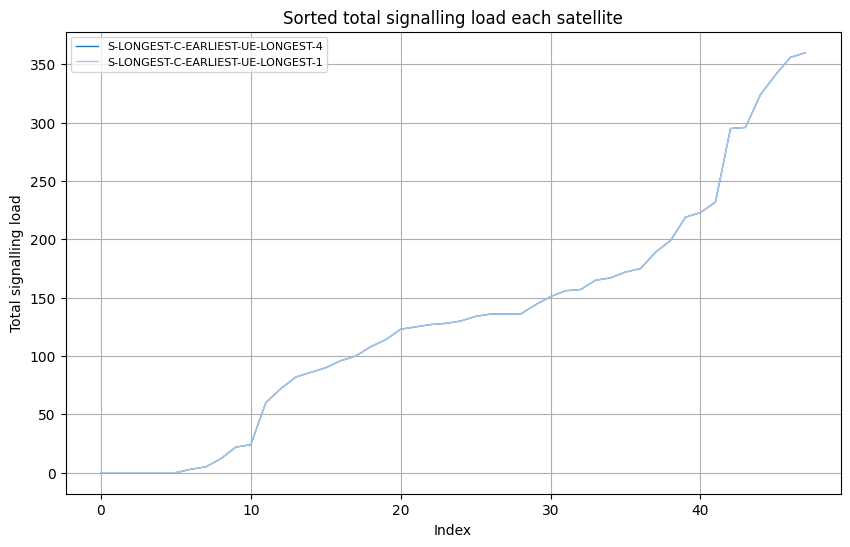

In [5]:
generate_numerical_results(result)
draw_total_load_each_satellite(result)

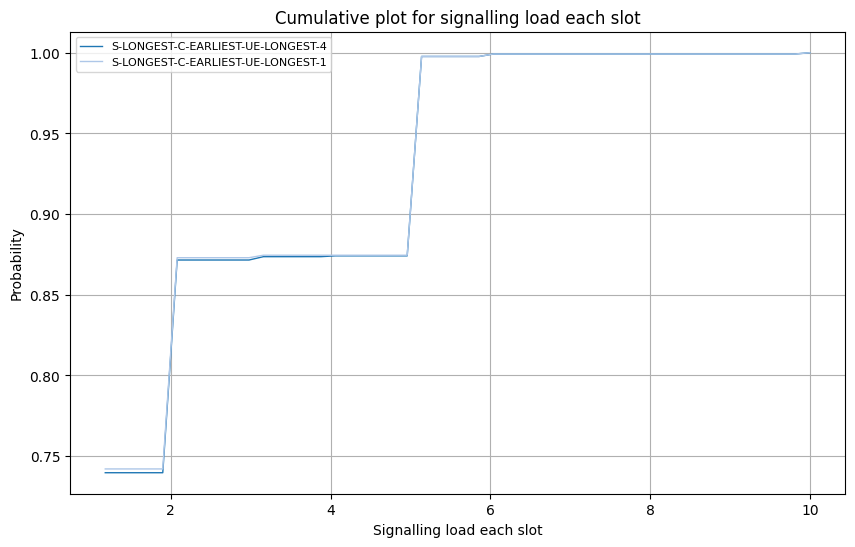

In [6]:
draw_cumulative_load_each_time(result)

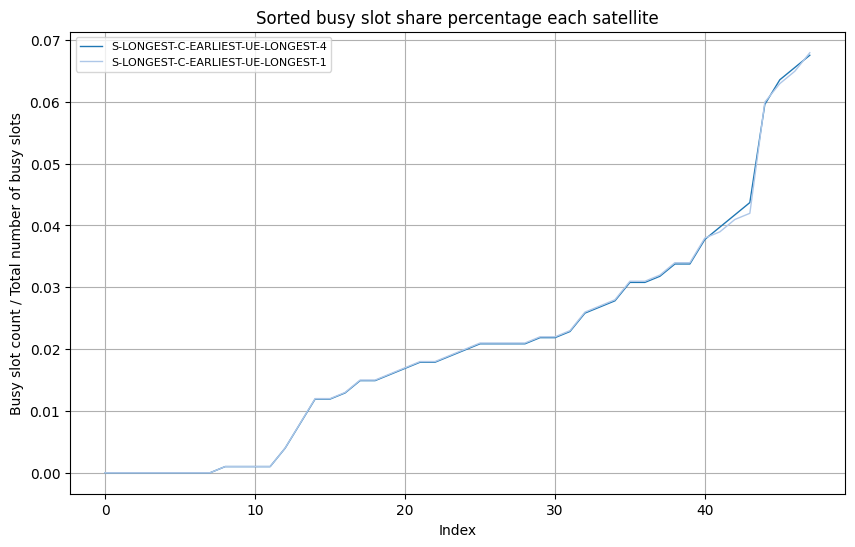

In [7]:
draw_busy_hour_distribution(result)

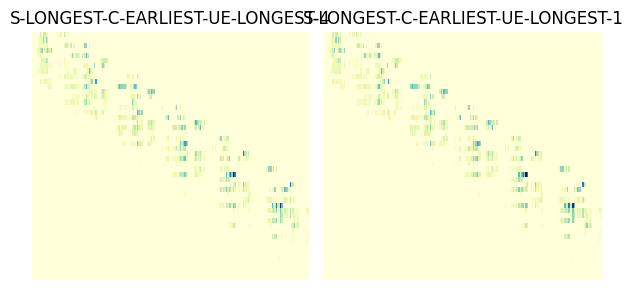

In [8]:
draw_heatmap(result, 100)

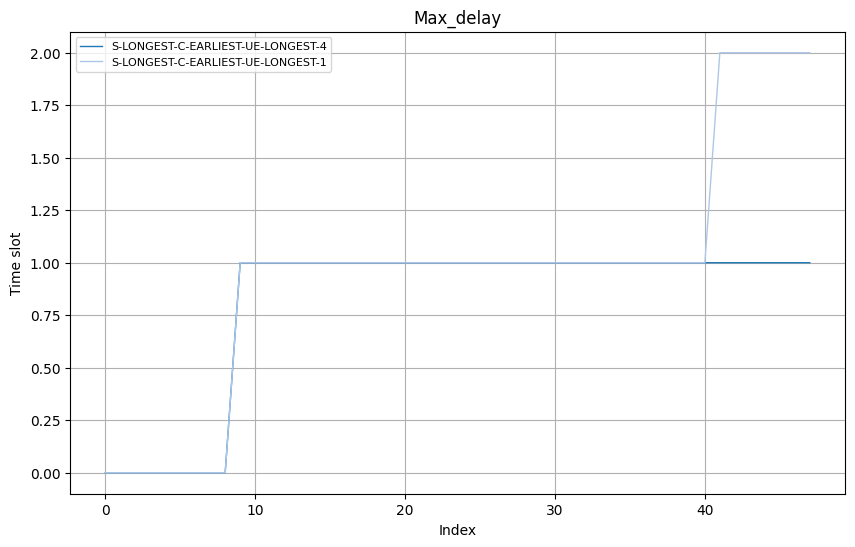

In [9]:
draw_max_access_slot(result)